Import libraries

In [ ]:
#import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re

Load Dataset

In [ ]:
#Load Dataset
df = pd.read_csv('restaurant_menu_1000.csv')

In [ ]:
# Display first few rows
df.head()

,Dish_ID,Dish_Name,Cuisine,Price,Rating,Veg_NonVeg
0,1,Butter Chicken 1,Chinese,327,4.4,Non-Veg
1,2,Burger 2,Chinese,131,3.7,Veg
2,3,Noodles 3,Indian,451,4.2,Non-Veg
3,4,Rasgulla 4,Indian,108,4.0,Non-Veg
4,5,Idli 5,Indian,380,3.9,Non-Veg


Data Cleaning & Preprocessing

In [ ]:
# Drop duplicates
df.drop_duplicates(inplace=True)

# Clean column names
df.columns = [col.strip().title() for col in df.columns]

# Normalize cuisine names
df['Cuisine'] = df['Cuisine'].str.strip().str.title()

# Encode Veg/Non-Veg
if 'Veg/NonVeg' in df.columns:
    df['Veg_NonVeg'] = df['Veg/NonVeg'].map({'Veg':1, 'Non-Veg':0})

# Handle missing values
df.fillna({'Rating': df['Rating'].mean(), 'Price': df['Price'].median()}, inplace=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Dish_Id     1000 non-null   int64  
 1   Dish_Name   1000 non-null   object 
 2   Cuisine     1000 non-null   object 
 3   Price       1000 non-null   int64  
 4   Rating      1000 non-null   float64
 5   Veg_Nonveg  1000 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 47.0+ KB


Exploratory Data Analysis (EDA)

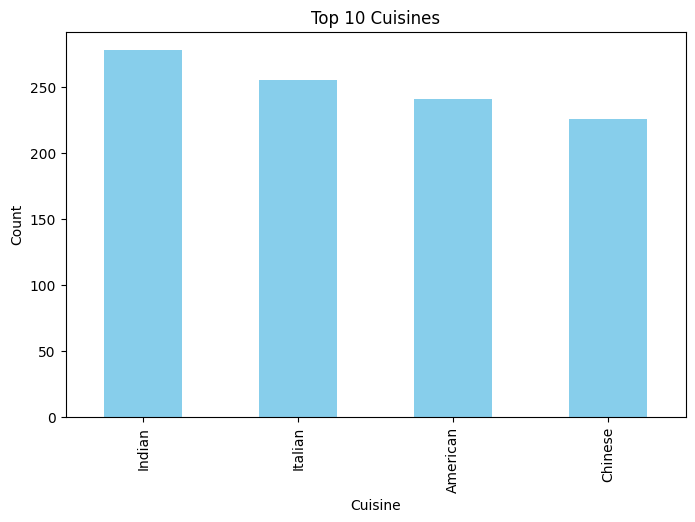

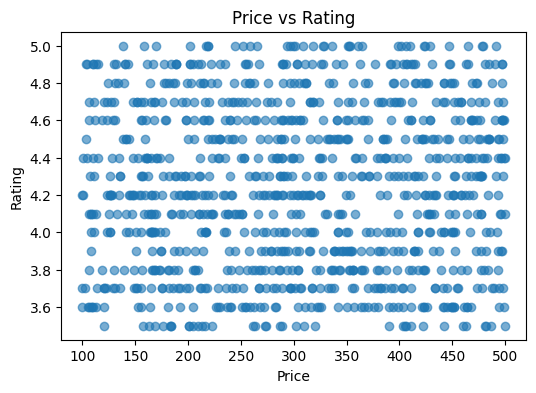

In [ ]:
# Exploratory Data Analysis
plt.figure(figsize=(8,5))
df['Cuisine'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Cuisines')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(df['Price'], df['Rating'], alpha=0.6)
plt.title('Price vs Rating')
plt.xlabel('Price')
plt.ylabel('Rating')
plt.show()


Feature Engineering

In [ ]:
# Combine text features for recommendation
df['Combined_Features'] = df['Cuisine'].astype(str) + ' ' + df['Dish_Name'].astype(str)

# Vectorize text features
cv = CountVectorizer(stop_words='english')
count_matrix = cv.fit_transform(df['Combined_Features'])

# Compute similarity
similarity = cosine_similarity(count_matrix)

print("Feature matrix shape:", count_matrix.shape)

Feature matrix shape: (1000, 1021)


Model Building - Menu Recommendation System

In [ ]:
# Function to recommend dishes
def recommend_dishes(dish_name, top_n=5):
    if dish_name not in df['Dish_Name'].values:
        return "Dish not found. Try another name."
    idx = df[df['Dish_Name'] == dish_name].index[0]
    scores = list(enumerate(similarity[idx]))
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    recommended = df.iloc[[i[0] for i in sorted_scores]][['Dish_Name','Cuisine','Price','Rating']]
    return recommended

# Example
recommend_dishes(df['Dish_Name'].iloc[0])

,Dish_Name,Cuisine,Price,Rating
7,Butter Chicken 8,Chinese,404,4.2
23,Butter Chicken 24,Chinese,336,4.4
57,Butter Chicken 58,Chinese,392,4.6
75,Butter Chicken 76,Chinese,173,4.4
284,Butter Chicken 285,Chinese,342,4.7


NLP Chatbot Logic

In [ ]:
def chatbot_response(user_input):
    user_input = user_input.lower()
    price_match = re.findall(r'\d+', user_input)
    cuisine_match = None
    for c in df['Cuisine'].unique():
        if c.lower() in user_input:
            cuisine_match = c
            break

    price_limit = int(price_match[0]) if price_match else None

    if cuisine_match and price_limit:
        result = df[(df['Cuisine']==cuisine_match) & (df['Price']<=price_limit)]
    elif cuisine_match:
        result = df[df['Cuisine']==cuisine_match]
    else:
        return "Please specify a cuisine or price range."

    if result.empty:
        return "No dishes found for your query."
    else:
        return result[['Dish_Name','Cuisine','Price','Rating']].head(5)

# Example chatbot interactions
chatbot_response("Show me Italian dishes under 300")

,Dish_Name,Cuisine,Price,Rating
11,Pasta 12,Italian,113,4.9
21,Gulab Jamun 22,Italian,271,4.2
37,Rasgulla 38,Italian,296,3.7
50,Biryani 51,Italian,229,4.4
51,Rasgulla 52,Italian,110,4.9


Model Evaluation

In [ ]:
# Evaluate recommendation diversity and relevance (basic example)
print("Unique cuisines recommended:", df['Cuisine'].nunique())
print("Average Rating:", round(df['Rating'].mean(), 2))


Unique cuisines recommended: 4
Average Rating: 4.24
